#### Tasks to Experiment
1. Increase Image Spacing ~30
2. Increase Image Resolution ~400
3. Reduce FF layers ~1
4. Add Regularization ~L2
5. Add BatchNorm Layers ~0
6. Change Loss Function ~ MAE
7. Change internal activation ~ LeakyReLU
8. Use optical Flow
9. Introduce correlation layer like in FlowNet
10. Increase input sequence length ~ 10




### Installing and Importing Libraries, Packages and Modules

In [ ]:
!pip install SSIM-PIL pyopencl keras-vis visualkeras tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, ConvLSTM2D, Conv2D, BatchNormalization, MaxPooling2D, Flatten, TimeDistributed, Dropout, Concatenate, LeakyReLU, ELU
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow_addons.layers import CorrelationCost
import visualkeras
from sklearn.model_selection import train_test_split
import os
import cv2 as cv
import numpy as np
import random
from SSIM_PIL import compare_ssim
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


### Data-Creating Functions and Generators

In [ ]:

class DataMakers:
    def __init__(self, dir):
        self.dir = dir

    def get_dataset_generator(self, batch_size=32, from_fr=0, n_frames=1000, k=0, spacing=1, fr_wi=100, fr_he=100, out_speeds=9, train_size=0.8, set_type="train", rnd_st=6):
      path = f'{self.dir}SpeedEstData/train_frames/'
      pool = sorted(os.listdir(path), key=lambda x: int(re.findall('frame(\d+).jpg', x)[0]))[from_fr : n_frames : spacing]
      with open(f'{self.dir}SpeedEstData/train.txt') as f:
        lines = f.readlines()
        lines = [round(float(l.replace('\n', '')), 2) for l in lines]  #made integer speeds here
        lines = [lines[l] for l in range(from_fr, n_frames, spacing)]
        speeds = np.array(lines)


      train_sample_ids, test_sample_ids = train_test_split(list(range(len(pool)-k)), train_size=train_size, shuffle=True, random_state=rnd_st)

      if set_type == "train":
            sample_ids = train_sample_ids
      else:
            sample_ids = test_sample_ids

      sample_id = 0
      while 1:
        x = np.empty( (batch_size, k, fr_wi, fr_he, 3), dtype=np.float16)
        y = np.empty( (batch_size, out_speeds))

        for i in range(x.shape[0]):
          if sample_id >= len(sample_ids):
            sample_id = 0

          frame_s = sample_ids[sample_id]
          frame_e = frame_s + k

          resize = lambda x : cv.resize(x, (fr_wi, fr_he))
          normalize = lambda x : cv.normalize(x , None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)

          x[i] = np.array([resize(cv.imread(path+pool[idd])*1./255)  for idd in range(frame_s, frame_e)])
          y[i] = speeds[frame_s+k-out_speeds:frame_e]
          sample_id += 1
        yield x, y

data_maker = DataMakers(dir='/content/mydrive/MyDrive/')

### Loading the Specified Data Generators

In [ ]:
from math import ceil, floor
batch_size = 8
dataset_start, dataset_end= 0, 20400   # train : dev : test = 90% : 5% : 5%
sequence_len = 4
skip = 10
out_speeds = 3
train_split = 0.8
im_res = 300


dataset_size = floor((dataset_end-dataset_start)/skip -sequence_len + 1)
train_size, test_size = floor(dataset_size*train_split), floor(dataset_size*(1-train_split))

train_gen = data_maker.get_dataset_generator(batch_size=batch_size, from_fr=dataset_start, n_frames=dataset_end, spacing=skip, k=sequence_len, fr_wi=im_res, fr_he=im_res, out_speeds=out_speeds, set_type="train", train_size=train_split, rnd_st=6)
train_steps = ceil(train_size/batch_size)

test_gen = data_maker.get_dataset_generator(batch_size=batch_size, from_fr=dataset_start, n_frames=dataset_end, spacing=skip, k=sequence_len, fr_wi=im_res, fr_he=im_res, out_speeds=out_speeds, set_type="test", train_size=train_split, rnd_st=6)
test_steps = ceil(test_size/batch_size)


In [ ]:
train_size, test_size, dataset_size

(1629, 407, 2037)

### Model Architectures

In [ ]:

class ModelArchs:
    def __init__(self):
        pass


    class PairwiseCorr(tf.keras.layers.Layer):

      def __init__(self, time_stamps, ksize=3, disp=10, s1=1, s2=2, pad=4):
        super(ModelArchs.PairwiseCorr, self).__init__()
        self.ts = time_stamps
        self.ksize = ksize
        self.disp = disp
        self.s1 = s1
        self.s2 = s2
        self.pad = pad


      def call(self, inputs):

        first = 1
        for time_step in range(self.ts-1):
          f1 = inputs[:, time_step, :, :, :]
          f2 = inputs[:, time_step+1, :, :, :]
          corr_out = CorrelationCost(kernel_size=self.ksize,max_displacement=self.disp,stride_1=self.s1,stride_2=self.s2,pad=self.pad,data_format="channels_last")([f1, f2])
          pairwise_out = tf.expand_dims(corr_out, axis=1)
          if first:
            pairwise_outs = pairwise_out
            first = 0
          else:
            pairwise_outs = Concatenate(axis=1)([pairwise_outs, pairwise_out])
        return pairwise_outs




    @classmethod
    def param_freezer(cls, base_model, except_layer_indices=[]):
      finetune_layers = except_layer_indices

      for ind in range(len(base_model.layers)):
        if ind in finetune_layers:
            base_model.layers[ind].trainable = True
        else:
            base_model.layers[ind].trainable = False

      return base_model

    def vgg19_pairwise_convlstm(self, time_stamps=10, im_res=400, conv_type="default", finetune_vgg19=False, out_one=False):
      X_inp = Input(shape=(time_stamps, im_res, im_res, 3))  #2 consecutive images concatenated
      feature_extractor_model = tf.keras.applications.vgg19.VGG19(
      include_top=False,
      weights='imagenet',
      input_tensor=None,
      input_shape=(im_res, im_res, 3),
      pooling=None)

      if conv_type == "default":
        pass
      else:
        print("Changing feature extractor's conv_type to : ", conv_type)
        for layer in feature_extractor_model.layers:
            if 'conv' in layer.name:
                layer.padding = conv_type
      print(feature_extractor_model.layers[1].padding)
      if finetune_vgg19:
        last_layer_index = len(feature_extractor_model.layers)-1
        layer_indices = [last_layer_index -1, last_layer_index-2]
        feature_extractor_model = ModelArchs.param_freezer(feature_extractor_model, layer_indices)
      else:
        layer_indices = []
        feature_extractor_model = ModelArchs.param_freezer(feature_extractor_model, layer_indices)


      X = TimeDistributed(feature_extractor_model)(X_inp)
      #diff = ModelArchs.PairwiseDiff(time_stamps=time_stamps)(X)
      corr = ModelArchs.PairwiseCorr(time_stamps=time_stamps, ksize=3, s1=1, s2=1, disp=3, pad=4)(X)
      #X = Concatenate(axis=-1)([diff, concat])
      X = ConvLSTM2D(filters=10, kernel_size=5, return_sequences=True, recurrent_activation='tanh', padding='valid', activation=LeakyReLU())(corr)
      X = ConvLSTM2D(filters=1, kernel_size=3, return_sequences=not(out_one), recurrent_activation='tanh', padding='valid', activation=LeakyReLU())(X)
      if not(out_one):
          X = TimeDistributed(Flatten())(X)
          Xout = TimeDistributed(Dense(1, activation='relu', kernel_regularizer=regularizers.L2(0.001)))(X)
      else:
          X = Flatten()(X)
          #X = BatchNormalization()(X)
          Xout = Dense(1, activation='relu', kernel_regularizer=regularizers.L2(0.001))(X)

      #X = ConvLSTM2D(filters=10, kernel_size=3, return_sequences=True, recurrent_activation=LeakyReLU(), padding='same')(X)
      #X = TimeDistributed(Dense(100, activation='linear'))(X)
      #X = TimeDistributed(Dense(25, activation='tanh'))(X)


      return Model(X_inp, Xout)


In [ ]:
#28*60 = x*1 ~ x=1680 kmph, training the given model at 60 spacing and for a 28kmph speed can be used to predict a max of 1680kmph for capture @ 30fps and produce frame every 30ms
#16*1 = x*1 ~ x =16kmph, training the given model at 1 spacing and for a 16kmph speed can be used to predict a min of 16kmph for capture @ 30fps and produce frame every 30ms

### Generator traininig

### Speed Predictions

In [ ]:
def outseq_to_series(gen, steps, prmodel, out_speeds=1):
    preds, Y = [], []
    for bt in range(steps):
        print(f"Batch {bt+1}/{steps}:")
        Xd,  y = next(gen)  #np.concatenate([x10, x20, x40, x60])
        pred = prmodel.predict(Xd)
        if bt == 0:
            preds = pred
            Y = y
        else:
            preds = np.concatenate([preds, pred])
            Y = np.concatenate([Y, y])

    if out_speeds == 1:
        true_speeds = list(np.squeeze(Y))
        pred_speeds = list(np.squeeze(preds))
    else:
        true_speeds = list(np.squeeze(Y[0])) + list(Y[1:, -1])
        pred_speeds = list(np.squeeze(preds[0])) + list(preds[1:, -1, 0])


    return true_speeds, pred_speeds

custom_objects = {"PairwiseCorr": ModelArchs.PairwiseCorr}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('/content/vgg19_pairwise_corr_convlstm-2_10space_4seq_120Ep_model.h5')

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mpe
from scipy.stats import spearmanr as r
from math import sqrt
from scipy.stats import spearmanr as r
from math import ceil, floor

batch_size = 8
dataset_start, dataset_end= 0, 20400   # train : dev : test = 90% : 5% : 5%
sequence_len = 4
skip = 10
out_speeds = 3
train_split = 0.8
im_res = 300

dataset_size = floor((dataset_end-dataset_start)/skip -sequence_len + 1)
train_size, test_size = floor(dataset_size*train_split), floor(dataset_size*(1-train_split))

train_gen = data_maker.get_dataset_generator(batch_size=batch_size, from_fr=dataset_start, n_frames=dataset_end, spacing=skip, k=sequence_len, fr_wi=im_res, fr_he=im_res, out_speeds=out_speeds, set_type="train", train_size=train_split, rnd_st=6)
train_steps = ceil(train_size/batch_size)

test_gen = data_maker.get_dataset_generator(batch_size=batch_size, from_fr=dataset_start, n_frames=dataset_end, spacing=skip, k=sequence_len, fr_wi=im_res, fr_he=im_res, out_speeds=out_speeds, set_type="test", train_size=train_split, rnd_st=6)
test_steps = ceil(test_size/batch_size)


In [ ]:
new_model.evaluate(test_gen)

In [ ]:
true_speeds_test, pred_speeds_test = outseq_to_series(test_gen, test_steps, new_model, out_speeds)

rmse = lambda x, y: sqrt(mse(x, y))

xr, yr = true_speeds_test, pred_speeds_test
print("MAE : ", mae(xr, yr))
print("MSE : ", mse(xr, yr))
print("RMSE : ", rmse(xr, yr))
print("R : ", r(xr, yr))
print("R^2 : ", r2_score(xr, yr))
print("MPE : ", mpe(xr, yr))

Batch 1/51:
1/1 [==============================] - 1s 1s/step
Batch 2/51:
1/1 [==============================] - 1s 609ms/step
Batch 3/51:
1/1 [==============================] - 1s 818ms/step
Batch 4/51:
1/1 [==============================] - 1s 864ms/step
Batch 5/51:
1/1 [==============================] - 1s 809ms/step
Batch 6/51:
1/1 [==============================] - 1s 605ms/step
Batch 7/51:
1/1 [==============================] - 1s 796ms/step
Batch 8/51:
1/1 [==============================] - 1s 789ms/step
Batch 9/51:
1/1 [==============================] - 1s 622ms/step
Batch 10/51:
1/1 [==============================] - 1s 614ms/step
Batch 11/51:
1/1 [==============================] - 1s 629ms/step
Batch 12/51:
1/1 [==============================] - 1s 605ms/step
Batch 13/51:
1/1 [==============================] - 1s 620ms/step
Batch 14/51:
1/1 [==============================] - 1s 634ms/step
Batch 15/51:
1/1 [==============================] - 1s 611ms/step
Batch 16/51:
1/1 [====

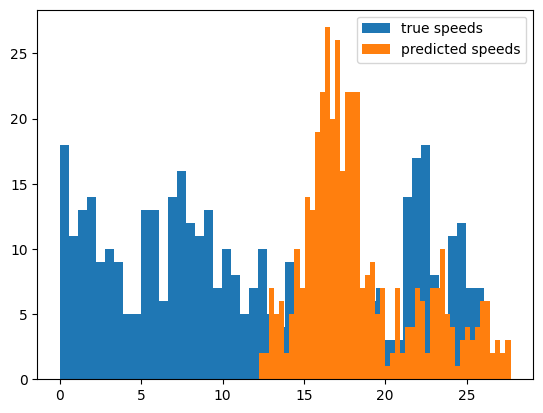

In [ ]:
import matplotlib.pyplot as plt
plt.hist(true_speeds_test, label="true speeds", bins=50)
plt.hist(pred_speeds_test, label="predicted speeds", bins=50)
plt.legend()
plt.savefig("output1.jpg")

SignificanceResult(statistic=0.4148414371404415, pvalue=1.744612682126924e-18)

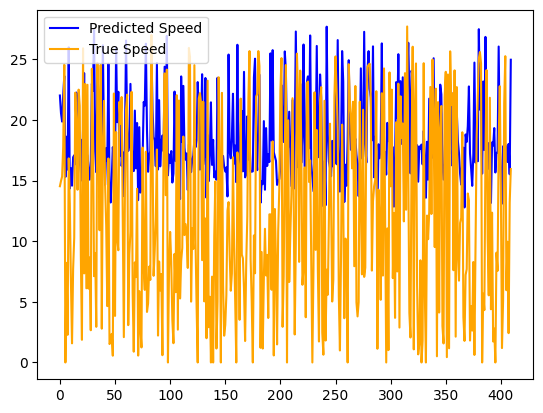

In [ ]:
st, en = 0, 2000
plt.plot(np.arange(len(pred_speeds_test[st:en])), pred_speeds_test[st:en], label='Predicted Speed', color='b')
plt.plot(np.arange(len(true_speeds_test[st:en])), true_speeds_test[st:en], label='True Speed', color='orange')
plt.legend()
from scipy import stats
stats.spearmanr(true_speeds_test[st:en], pred_speeds_test[st:en])
plt.savefig("output2.jpg")

SignificanceResult(statistic=0.4692307692307693, pvalue=0.002255260255236795)

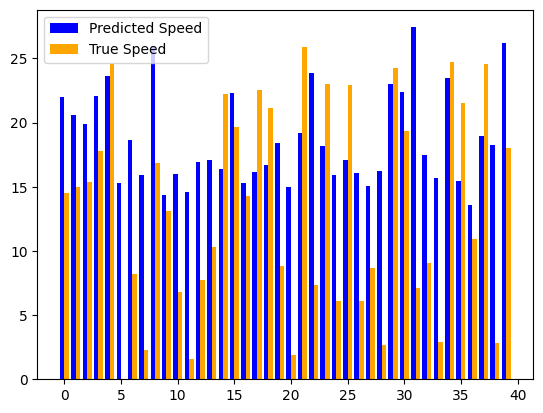

In [ ]:
st, en = 0, test_size//10
plt.bar(np.arange(len(pred_speeds_test[st:en]))-0.2, pred_speeds_test[st:en], 0.4, label='Predicted Speed', color='b')
plt.bar(np.arange(len(true_speeds_test[st:en]))+0.2, true_speeds_test[st:en], 0.4, label='True Speed', color='orange')
plt.legend()
from scipy import stats
stats.spearmanr(true_speeds_test[st:en], pred_speeds_test[st:en])
plt.savefig("output3.jpg")

In [ ]:
true_speeds_train, pred_speeds_train = outseq_to_series(train_gen, train_steps, new_model, out_speeds= out_speeds)

xr, yr = true_speeds_train, pred_speeds_train

print("MAE : ", mae(xr, yr))
print("MSE : ", mse(xr, yr))
print("RMSE : ", rmse(xr, yr))
print("R : ", r(xr, yr))
print("R^2 : ", r2_score(xr, yr))
print("MPE : ", mpe(xr, yr))

Batch 1/204:
1/1 [==============================] - 1s 841ms/step
Batch 2/204:
1/1 [==============================] - 1s 842ms/step
Batch 3/204:
1/1 [==============================] - 1s 634ms/step
Batch 4/204:
1/1 [==============================] - 1s 614ms/step
Batch 5/204:
1/1 [==============================] - 1s 613ms/step
Batch 6/204:
1/1 [==============================] - 1s 645ms/step
Batch 7/204:
1/1 [==============================] - 1s 637ms/step
Batch 8/204:
1/1 [==============================] - 1s 653ms/step
Batch 9/204:
1/1 [==============================] - 1s 608ms/step
Batch 10/204:
1/1 [==============================] - 1s 610ms/step
Batch 11/204:
1/1 [==============================] - 1s 607ms/step
Batch 12/204:
1/1 [==============================] - 1s 617ms/step
Batch 13/204:
1/1 [==============================] - 1s 617ms/step
Batch 14/204:
1/1 [==============================] - 1s 614ms/step
Batch 15/204:
1/1 [==============================] - 1s 619ms/step
Batc

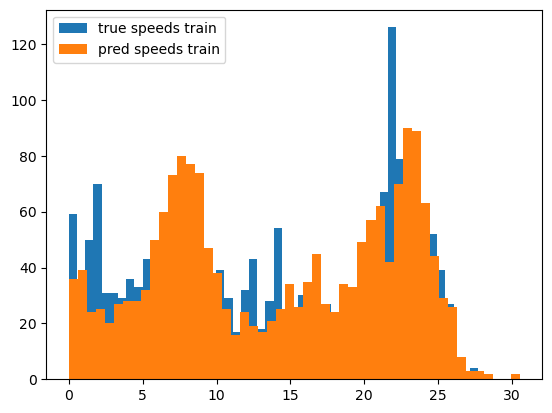

In [ ]:
import matplotlib.pyplot as plt
plt.hist(true_speeds_train, label="true speeds train", bins=50)
plt.hist(pred_speeds_train, label="pred speeds train", bins=50)
plt.legend()
plt.savefig("output4.jpg")

SpearmanrResult(correlation=0.9175050301810864, pvalue=2.4453935032649345e-29)

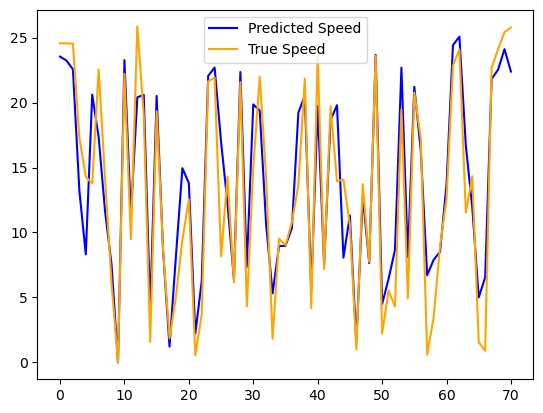

In [ ]:
st, en = 0, train_size//25
plt.plot(np.arange(len(pred_speeds_train[st:en])), pred_speeds_train[st:en], label='Predicted Speed', color='b')
plt.plot(np.arange(len(true_speeds_train[st:en])), true_speeds_train[st:en], label='True Speed', color='orange')
plt.legend()
from scipy import stats
stats.spearmanr(true_speeds_train[st:en], pred_speeds_train[st:en])
plt.savefig("output5.jpg")

SpearmanrResult(correlation=0.9175050301810864, pvalue=2.4453935032649345e-29)

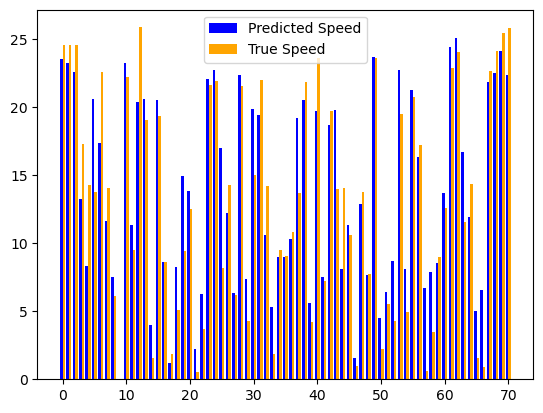

In [ ]:
st, en = 0, train_size//25
plt.bar(np.arange(len(pred_speeds_train[st:en]))-0.2, pred_speeds_train[st:en], 0.4, label='Predicted Speed', color='b')
plt.bar(np.arange(len(true_speeds_train[st:en]))+0.2, true_speeds_train[st:en], 0.4, label='True Speed', color='orange')
plt.legend()
from scipy import stats
stats.spearmanr(true_speeds_train[st:en], pred_speeds_train[st:en])
plt.savefig("output6.jpg")